# Solving DIfferential Equations

[Original code](https://github.com/Datseris/Zero2Hero-JuliaWorkshop/blob/master/3-Ecosystem.ipynb)

1. Take ODE and make it a Julia function `f`
2. Combine this function `f` and initial conditions, parameters and define an ODEProblem (Struct)
3. Choose solver
4. Solve the equations

In [1]:
using OrdinaryDiffEq, StaticArrays

`StaticArrays` provides static arrays which are immutable. 

#### Step 1: Make the set of ODES as a Julia function f


In [2]:
function lorentz_func(u, p, t)
    """
    ODE function
    u : [x, y ,z]
    p : [σ, ρ, β]
    t : (0, T)
    """
    x, y, z = u 
    σ, ρ, β = p
    
    ẋ = σ*(y-x)
    ẏ = x*(ρ-z)-y
    ż = x*y-β*z
    
    return SVector( ẋ, ẏ, ż )
end

lorentz_func (generic function with 1 method)

#### Step 2: Define an ODE problem: f, initial state, a parametr container

In [3]:
#initial state
u₀ = SVector(10.0, 10.0, 10.0)
#parameters
p  = [10.0, 28.0, 8.0/3.0]
# time span
tspan = (0.0, 100.0)
# define ODE problem
prob = ODEProblem(lorentz_func, u₀, tspan, p)

ODEProblem with uType SArray{Tuple{3},Float64,1,3} and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: [10.0, 10.0, 10.0]

#### Step 3: Choose solver

In [4]:
# step 3: Choose algorithem as solver
alg   =  Vern9()             # 9th order adaptive RK method 

Vern9(true)

#### Step 4: Solve the ODE using `solve` 

In [5]:
sol   = solve(prob, alg=alg )

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 902-element Array{Float64,1}:
   0.0
   0.09355226310426
   0.17283944628206213
   0.24997046635545134
   0.33111610744803827
   0.42743131783646965
   0.5201140913658462
   0.6242605175854586
   0.7340052492650533
   0.8380149776590866
   0.9438866257985115
   1.0545811111840224
   1.1789855148275294
   ⋮
  98.86131214292969
  98.966663437393
  99.07194022267977
  99.19597178668509
  99.33755089044504
  99.44051282392593
  99.54192389117195
  99.62958862392502
  99.74154878708663
  99.84341219700966
  99.96495889802289
 100.0
u: 902-element Array{SArray{Tuple{3},Float64,1,3},1}:
 [10.0, 10.0, 10.0]
 [14.527288897352587, 21.12071452189923, 24.655401013820843]
 [16.260683509932253, 11.98774098852595, 40.866652625646566]
 [9.410451093456127, -1.345343845837725, 37.613015846596966]
 [2.332877467383761, -3.820315512793081, 29.11993614068686]
 [-1.363730916283803, -3.6200129433647934, 22.48755819939663]
 [-3.0793598

## Analyzing the solution

The `sol` object have the information on time (`sol.t`) and the solution states (`sol.u`)

*But how did this work? We didnt specified at which time point to save the solution ?* 

Remember that the solver we have chosen is an adaptive solver. This means the solver decides itself what the step size should be. So the time points you see in the `sol.t` are arbitrary which are chosen by the algorithem itself as an optimial time step.

First let us access the data

In [6]:
(sol.t[3], sol.u[3])

(0.17283944628206213, [16.260683509932253, 11.98774098852595, 40.866652625646566])

Another alternative method to extract the same reustls is 

In [7]:
sol[1,3]   # sol[x[3]]

16.260683509932253

Ok let us plot the solutions in 3D

In [ ]:
using PyPlot

In [ ]:
plot3D(sol[1,:], sol[2,:], sol[3,:])

You see that the time step shown in the above image is too course to visualize. Because of the mechanics of the solver you can get the Interpolation. This means that we can get the solution at anytime inbetween two time snapshots. 

In otherwords we can call `sol` as a function to give us the value of `u` at any time point within timespan. For example

In [ ]:
sol.t[1:4]

let us findou the values of `u` at the time `t=0.02`

In [ ]:
sol(0.02)

The solver tried to interpolate the solution between `t=0.17283944628206213` and `t= 0.24997046635545134` and it will give us a 9-th order accuracy of the true solution at this time point. So we can take advantage of this method and we can get data of any mesh size in time.

In [ ]:
# define uniform time grid
t = 0:0.01:10

In [ ]:
X, Y, Z = zero(t), zero(t) ,zero(t)
print(size(X))

In [ ]:
for (i, τ) in enumerate(t)
    X[i], Y[i], Z[i] = sol(τ)
end

In [ ]:
plot3D(X,Y,Z)

We see that the solution plotted is much smooth as we used the uniform grid for time t.

# Numbers in Uncertainity

Imagine a situation where you have an experimental data for the initial condition of a differential equation. Quite often the experimental measurements are assosiated with error bars. for example $x = 0.5 \pm 0.03 $ . In that case we need to understand how the error propogates in time during solving the differential equations (Integration). In this situation the module, `Measurements` can help us.

The module `Measurements` provide numeric types that have error bars; so that your numeric operations propagate the errors as is done in experimentla physics. (math behind this module: linear error theory ) So with this you can solve a differential equation of numbers with error bars! and your solution will itself be a sequence of numbers with properly calculated errorbars

Let us see an example

In [ ]:
using Measurements

In [ ]:
x = 0.5 ± 0.03

The measurements provides the function $\pm$ to create a numbe 0.5 acompanied with error 0.03

In [ ]:
Measurements.value(x)

In [ ]:
Measurements.uncertainty(x)

In [ ]:
typeof(x)

now we can do operations with this type 

In [ ]:
x + 3.0

In [ ]:
x*(0.4 ± 0.02)

#### Using `Measurements` module for Lorentz problem

We will now chage the initial condition as  a vector of three numbers with errors associated with each element

In [ ]:
uunc = SVector(10.0 ± 0.1, 10.0 ± 0.1, 10.0 ± 0.1)

Now we again createa new problem to solve lorentz equation now with an exection that the inital state is associated with some errors

In [ ]:
probunc = ODEProblem(lorentz_func, uunc, tspan, p)

In [ ]:
solunc = solve(probunc; alg=alg)

As you can see that in the actual solution state that all of them have the errorrs. As you know that for a lorentz system these error go to infinity at some point.

Now for our understanding we will look at the error propagation for the first variable `x` 

In [ ]:
t = 0:0.05:5
Xunc = [solunc(τ)[1] for τ in t]

In [ ]:
X_values = Measurements.value.(Xunc)         # get the values
X_unc    = Measurements.uncertainty.(Xunc)   # get errors

In [ ]:
using Plots

In [ ]:
# plot errors 
Plots.plot(t,X_values)
# plot two curves [time vs value+error], [time vs value-error] and fill the area between them
fill_between(t, X_values-X_unc , X_values+X_unc, color="C3",alpha=0.5)

## [Event Handling](https://diffeq.sciml.ai/stable/features/callback_functions/)

Imagine that you are a curious kid and you want to see waht happens if I give a kick to the Lorentz dynamical system at a particular time. You can do this with the `Callback` interface. Remember that the procedure to solve the differential equations of dynamical system is that we start with an initial condition and then we try to find the solution for a very small increment step, untill we reach the final time tspan. So you want to change the variables of the dynamicsl system at a particular time (kick) and you want to see how the system behaves from that point of time. This is called event handling

The way this event handling works is that 
1. **Event trigger**: first you define some kind of condition w.r.t when this even must trigger

2. **affect**: Next you define another function `effect function` that says what happens once the event is triggered 

#### Example

We will define a condition (event trigger) that whenever the second variable of lorentz system (y) become zero then apply the following affect: change the state of the integrator to decrease the third variable `z` little bit `z_new = 0.9*z`

In [ ]:
condition(u, t, integrator) = u[2]

affect!: This is the function affect!(integrator) where one is allowed to modify the current state of the integrator

In [ ]:
function affect!(integrator)         # !! to be inplace
    u = integrator.u
    integrator.u = (u[1], u[2], 0.9u[3])
end

Now we will use the  ContinuousCallback type to apply when a continuous condition function hits zero. 

In [133]:
my_callback = ContinuousCallback(condition, affect!)

ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing,Int64}(condition, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0)

In [134]:
# define the problem (without errors this time)
prob = ODEProblem(lorentz_func, u₀, (0.0, 10.0), p)

ODEProblem with uType SArray{Tuple{3},Float64,1,3} and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: [10.0, 10.0, 10.0]

In [135]:
# add keyword argument callback to the solverfunction

In [136]:
sol = solve(prob; alg = Vern9(), callback = my_callback)

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 132-element Array{Float64,1}:
  0.0
  0.09355226310426
  0.17283944628206213
  0.23702109730820153
  0.23702109730820153
  0.31415211738159077
  0.4083491661247245
  0.4962279081884818
  0.5857495966183466
  0.6899682852756027
  0.8023037781881516
  0.905119094287431
  1.0065773599725418
  ⋮
  9.277836640700244
  9.374939191672675
  9.391355512278182
  9.391355512278182
  9.497998582802209
  9.601811310109515
  9.718366106245684
  9.837972141842444
  9.941707141815993
  9.994468612534792
  9.994468612534792
 10.0
u: 132-element Array{SArray{Tuple{3},Float64,1,3},1}:
 [10.0, 10.0, 10.0]
 [14.527288897352587, 21.12071452189923, 24.655401013820843]
 [16.260683509932253, 11.98774098852595, 40.866652625646566]
 [10.81095497039061, 1.978861519091879e-12, 39.02687502773689]
 [10.81095497039061, 1.978861519091879e-12, 35.124187524963205]
 [4.105670336545883, -2.0815995368006788, 27.896245371993484]
 [0.5598789200691954

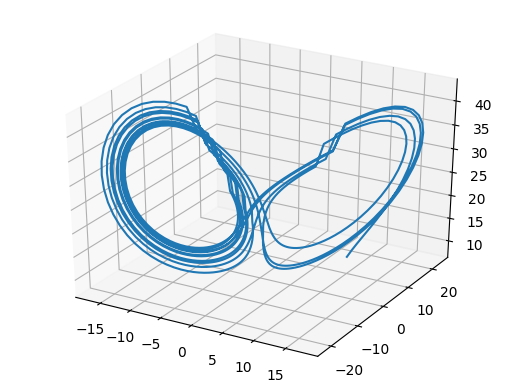

1-element Array{PyCall.PyObject,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x14c865e41be0>

In [138]:
# define uniform time grid
t = 0:0.01:10
X, Y, Z = zero(t), zero(t) ,zero(t)
for (i, τ) in enumerate(t)
    X[i], Y[i], Z[i] = sol(τ)
end
plot3D(X,Y,Z)

#### You see that whenever y=0, the graph have jumps toward bottom (z_new = 0.9*z) 

┌ Info: Saved animation to 
│   fn = /nethome/storage/raid1/n.kusampudi/Julia_navy/tmp.gif
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/animation.jl:104


Plots.AnimatedGif("/nethome/storage/raid1/n.kusampudi/Julia_navy/tmp.gif")
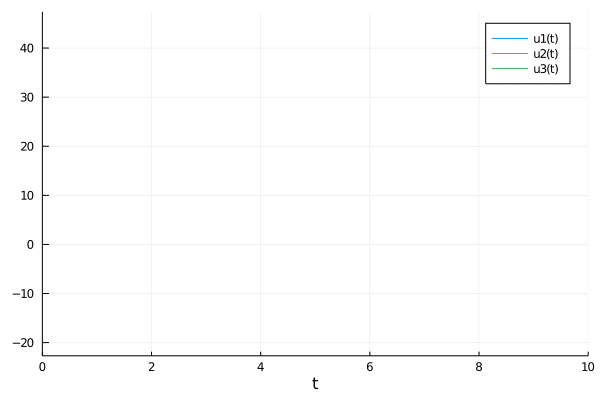

In [147]:
animate(sol,lw=3,every=1)

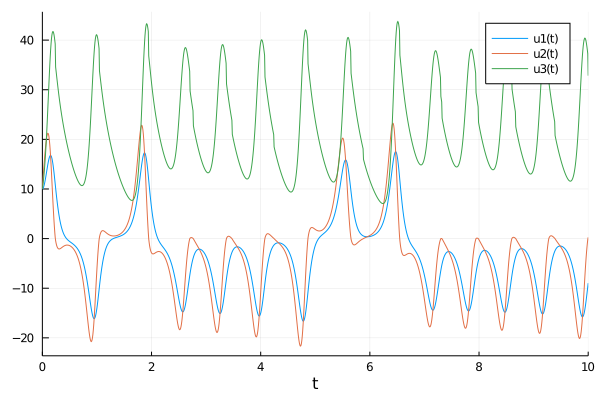

In [144]:
Plots.plot(sol, vars=(0,1:3))

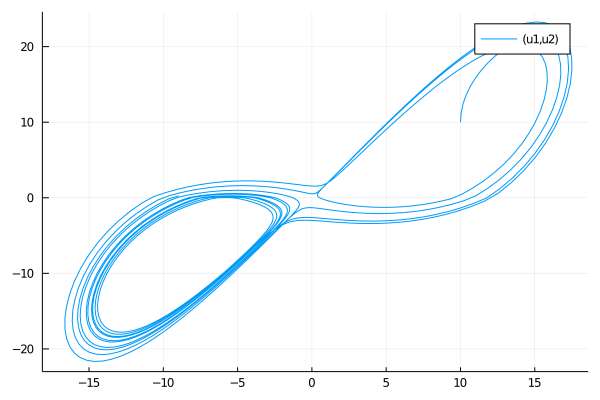

In [140]:
Plots.plot(sol, vars=(1,2))

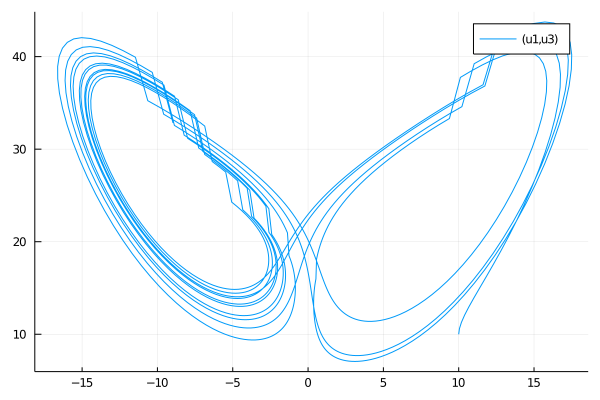

In [141]:
Plots.plot(sol, vars=(1,3))

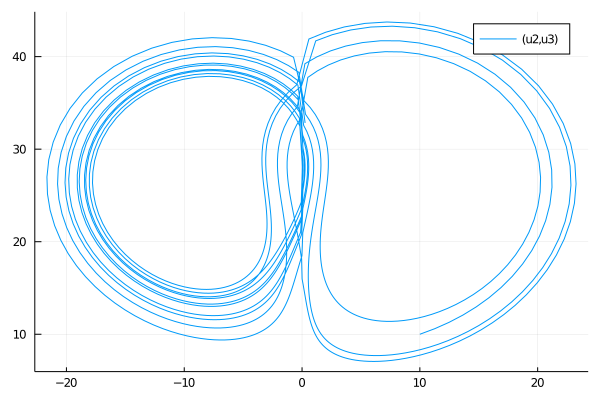

In [142]:
Plots.plot(sol, vars=(2,3))

# [DynamicalSystems.jl](https://github.com/JuliaDynamics/DynamicalSystems.jl)

`DynamicalSystems.jl` is an award winning library for nonlinear dynamics and Chaos. It is build on top of `DifferentialEquations.jl` to evolve systems in time. 

In [152]:
using DynamicalSystems

In [153]:
lorentz = ContinuousDynamicalSystem(lorentz_func, u₀, p)

3-dimensional continuous dynamical system
 state:       [10.0, 10.0, 10.0]
 e.o.m.:      lorentz_func
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [10.0, 28.0, 2.6666666666666665]

Now we can use the `lorentz` object in various functions of the library. For example, to obtain the Lyapunov spectrum 

#### Lyaponov number

In [154]:
lyapunovs(lorentz, 10000) # 2nd argument is for how much time to evolve

3-element Array{Float64,1}:
   0.9039371688586841
  -2.201151899580571e-5
 -14.570557897363727

The above function evolved the lorentz system internally and created the tangent space to calculate lyaponov exponents

#### Poincare section

to obtain Poincare surface of the section with the plane that (for ex.) the `y` variable crosses zero

In [160]:
plane = (2, 0.0) # when my 2nd variable, y crosses 0.0
psos  = poincaresos(lorentz, plane, 1000.0)

3-dimensional Dataset{Float64} with 476 points
  -7.10792   -3.66265e-7   33.0688
 -11.5291    -3.14584e-9   40.5135
   2.24303   -6.15224e-12  24.2377
  -7.09758   -2.29198e-7   33.0521
 -11.5026    -1.91843e-9   40.4678
   1.97185    2.285e-9     23.6029
  -6.36179   -1.0439e-6    31.8233
 -10.1942    -2.49149e-9   38.2322
   3.34247    2.59029e-6   26.5141
  -8.63591   -1.86515e-7   35.614
  -7.42905   -3.67076e-7   33.604
 -12.9019    -4.30439e-10  42.9089
   0.36134   -1.21471e-10  17.5907
   ⋮                       
  -8.64694   -2.2795e-7    35.6321
  -7.49088   -4.44474e-7   33.7069
 -13.8631    -1.37158e-8   44.6206
  -9.88093   -1.15107e-7   37.7025
   1.48638   -9.72846e-10  22.338
  -8.1977    -1.90012e-7   34.883
  -7.58548   -3.62746e-8   33.8638
  -5.36086   -4.32412e-7   30.1306
  -9.28587   -6.20987e-8   36.7013
 -10.6931     1.32382e-8   39.0799
   0.763925  -2.1828e-10   19.8526
  -6.70268   -3.30653e-7   32.3929

┌ Warning: linestyle 1 is unsupported with Plots.GRBackend().  Choose from: [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:1195


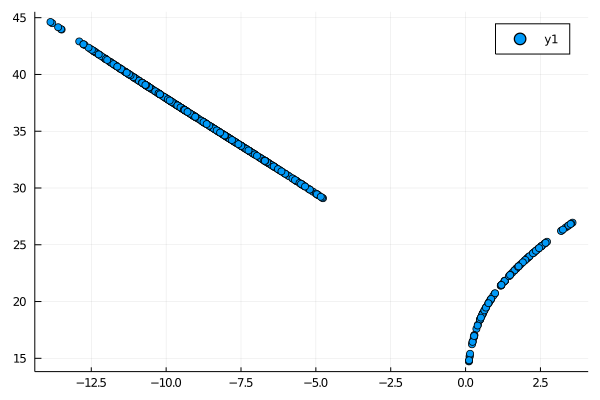

In [168]:
# plotting poincare section
Plots.scatter(psos[:,1], psos[:,3], s=1)

# Nonlinear Timeseries Analysis

Advanced nonlinear timeseries analysis are included in the package. 

For example if you have a nice trajectory sampled at discrete times (which is what the function `trajectory` does). This is just a wrapper for `solve` function we have seen earlier

In [169]:
tr = trajectory(lorentz, 1000.0; dt=0.05)

3-dimensional Dataset{Float64} with 20001 points
  10.0         10.0       10.0
  11.6604      17.4659    15.75
  14.9431      21.227     26.2311
  16.7587      16.6772    37.8091
  14.4989       6.06744   41.6612
   9.40731     -1.34788   37.6097
   4.5647      -3.65188   32.0526
   1.27841     -3.76227   27.5651
  -0.660687    -3.58262   24.0887
  -1.83235     -3.75926   21.3038
  -2.72165     -4.46127   19.0841
  -3.66336     -5.7684    17.464
  -4.89541     -7.77907   16.6366
   ⋮                      
  -8.7667     -14.7776    16.5172
 -11.9634     -18.3725    22.6565
 -14.5968     -17.9932    31.5653
 -14.751      -11.7214    38.2464
 -11.8535      -4.01615   38.369
  -7.72111      0.296008  34.3243
  -4.24419      1.48778   29.7596
  -1.98705      1.41035   25.8345
  -0.714311     1.11662   22.5334
  -0.0343316    0.956168  19.7044
   0.357267     0.996214  17.2529
   0.654459     1.24426   15.126

The above result is not a matrix, but a vector of vectors. This `tr` represents in fact the attractor of the lorentz system, since this is what we just evolved in time. Typically one is intrested in the entropy of this attractor, by partitioning the state space in boxes of size $\epsilon$

Now with this trajectory we can compute its Rényi entropy. 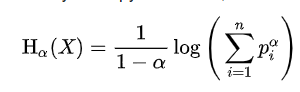
In the context of fractal dimension estimation, the Rényi entropy forms the basis of the concept of generalized dimensions.

    syntax:  genentropy(α,ε,tr)
    
   ε is the size of the voxel

In [170]:
H = genentropy(1, 0.1, tr)  # 

9.837529474680585

In [171]:
H = genentropy(1, 0.01, tr)  # 

9.90353755128635

This quantity is interesting because it can be used to calculate the fractal dimension of the trajectory. The way it works is that: You look at how `H` changes for varying ε. If `D` is the fractal dimension of trajectory, then it typically holds that `H ~ ε ^(-D)`

In reality what one does is calculate `H` for many different ε and plot the result, and then manually identify the slope of the curve `H` vs. $-log(\varepsilon)$

In [174]:
εS = ℯ .^(-8:0.5:8)

33-element Array{Float64,1}:
    0.00033546262790251185
    0.0005530843701478336
    0.0009118819655545162
    0.0015034391929775724
    0.0024787521766663585
    0.004086771438464067
    0.006737946999085467
    0.011108996538242306
    0.01831563888873418
    0.0301973834223185
    0.049787068367863944
    0.0820849986238988
    0.1353352832366127
    ⋮
   12.182493960703473
   20.085536923187668
   33.11545195869231
   54.598150033144236
   90.01713130052181
  148.4131591025766
  244.69193226422038
  403.4287934927351
  665.1416330443618
 1096.6331584284585
 1808.0424144560632
 2980.9579870417283

In [177]:
HS = genentropy.(1,εS, Ref(tr) )

33-element Array{Float64,1}:
  9.90353755128635
  9.90353755128635
  9.90353755128635
  9.90353755128635
  9.90353755128635
  9.90353755128635
  9.90353755128635
  9.90353755128635
  9.90312168377139
  9.900557167429135
  9.891269459595035
  9.860042707793426
  9.78074383756112
  ⋮
  2.702396852726326
  1.9641564466046155
  0.821385539477985
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

In [178]:
xs = -log.(εS)

33-element Array{Float64,1}:
  8.0
  7.5
  7.0
  6.5
  6.0
  5.5
  5.0
  4.5
  4.0
  3.5
  3.0
  2.5
  2.0
  ⋮
 -2.5
 -3.0
 -3.5
 -4.0
 -4.5
 -5.0
 -5.5
 -6.0
 -6.5
 -7.0
 -7.5
 -8.0

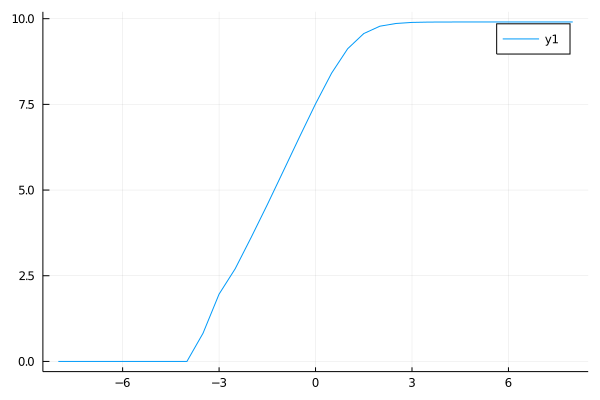

In [180]:
Plots.plot(xs, HS)

One can clearly identify the region in the middle which has slope of `D`, the fractal dimension of  our trajectory. 

In [186]:
lrs, slopes = linear_regions(xs, HS, tol = 0.25)

for i in 1:length(lrs)-1
    Plots.plot(xs[lrs[i]:lrs[i+1]], HS[lrs[i]:lrs[i+1]], marker = "o", 
        label = i > 7 ? "slope $(round(slopes[i]; digits = 3))" : "")
end

┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker arg o.
└ @ Plots /nethome/n.kusampudi/.julia/packages/Plots/hyS17/src/args.jl:830
┌ Warning: Skipped marker ar

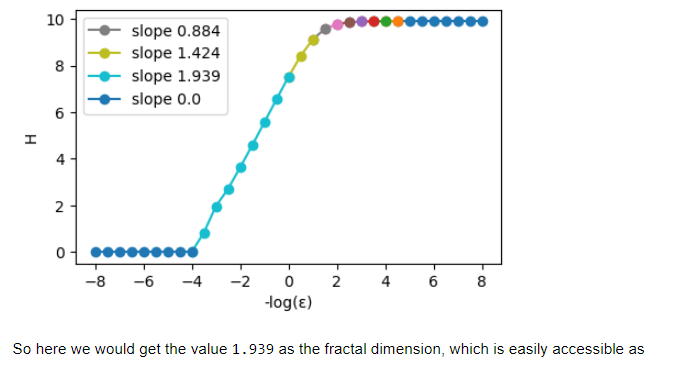

In [189]:
D = maximum(slopes)

1.9387874361172148

In [ ]:
fit()